## MNIST

In [1]:
#загрузка библиотек 
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
raw_data = datasets.MNIST(root='.', train=True, download=True)

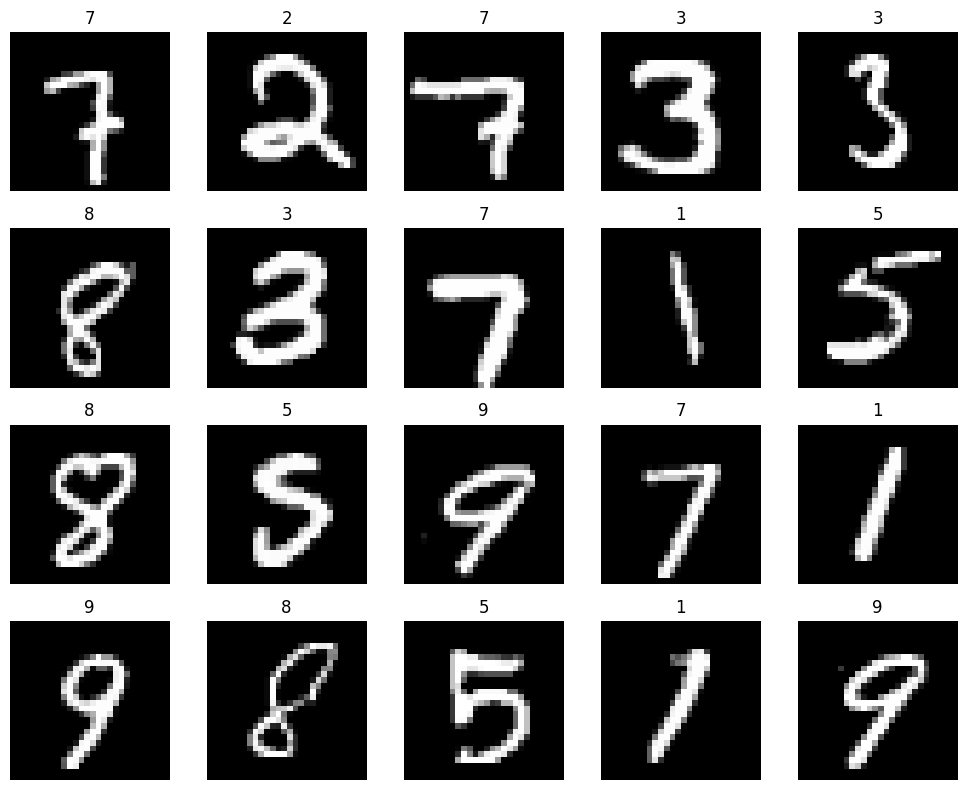

In [4]:
rand = torch.randint(0,len(raw_data),(20,))
fig, axes = plt.subplots(4, 5, figsize = (10,8))

for i, ind in enumerate(rand):
    image , number = raw_data[ind]
    row, col = divmod(i,5)
    axes[row,col].imshow(image,cmap= 'gray')
    axes[row,col].set_title(number)
    axes[row,col].axis('off')

plt.tight_layout()
plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x :  x.view(-1)) 
]) 
train_data = datasets.MNIST(root='.', train=True, download=True, transform= transform)
test_data = datasets.MNIST(root='.',train=False,download=True, transform = transform)
train_loader = DataLoader(train_data,64,shuffle= True)
test_loader = DataLoader(test_data,64)

In [6]:
#проверка размера batch
for batch in train_loader:
    inputs, labels = batch
    print(inputs.shape, labels.shape)
    break


torch.Size([64, 784]) torch.Size([64])


In [7]:
#модель
class MyNeuraNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
    def forward(self,x):
        return self.model(x)

In [8]:
#проверка вывода
model = MyNeuraNet()
x = torch.range(1,784)

outputs = model(x) 
print(outputs.shape)
print(outputs)
print(torch.softmax(outputs, dim = 0))


torch.Size([10])
tensor([-1.3565e+01,  2.0573e-02,  1.5519e+01,  1.0541e+01, -2.6461e+01,
         2.9445e+01, -4.4212e+01,  4.3118e+01, -6.3949e+00,  9.2695e+00],
       grad_fn=<ViewBackward0>)
tensor([2.4152e-25, 1.9185e-19, 1.0326e-12, 7.1113e-15, 6.0582e-31, 1.1528e-06,
        1.1834e-38, 1.0000e+00, 3.1389e-22, 1.9941e-15],
       grad_fn=<SoftmaxBackward0>)


/var/folders/gj/56f54n8n2sqbwjncq6lzjn_r0000gn/T/ipykernel_67579/299119752.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(1,784)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range (20):
    total_loss = 0 
    for batch in train_loader:
        inputs, labels = batch 
        outputs = model(inputs) # прямой проход
        loss = loss_fn(outputs, labels) # считаем прямой проход

        optimizer.zero_grad() #обнуляем градиенты
        loss.backward() # обратный проход 
        optimizer.step() # обновляем веса

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1} - Loss: {avg_loss:.4f}')


Epoch 1 - Loss: 0.3080
Epoch 2 - Loss: 0.1143
Epoch 3 - Loss: 0.0774
Epoch 4 - Loss: 0.0586
Epoch 5 - Loss: 0.0458
Epoch 6 - Loss: 0.0337
Epoch 7 - Loss: 0.0303
Epoch 8 - Loss: 0.0245
Epoch 9 - Loss: 0.0229
Epoch 10 - Loss: 0.0202
Epoch 11 - Loss: 0.0171
Epoch 12 - Loss: 0.0153
Epoch 13 - Loss: 0.0164
Epoch 14 - Loss: 0.0123
Epoch 15 - Loss: 0.0112
Epoch 16 - Loss: 0.0109
Epoch 17 - Loss: 0.0133
Epoch 18 - Loss: 0.0087
Epoch 19 - Loss: 0.0082
Epoch 20 - Loss: 0.0108


In [10]:
model.eval()  # режим оценки
correct = 0
total = 0

class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = preds[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"\nОбщая точность: {accuracy:.4f}")

# Точность по каждому классу
for i in range(10):
    acc = class_correct[i] / class_total[i]
    print(f"Точность для {i}: {acc:.4f}")



Общая точность: 0.9806
Точность для 0: 0.9929
Точность для 1: 0.9894
Точность для 2: 0.9826
Точность для 3: 0.9832
Точность для 4: 0.9705
Точность для 5: 0.9776
Точность для 6: 0.9843
Точность для 7: 0.9815
Точность для 8: 0.9723
Точность для 9: 0.9703


Модель показала отличную точность для всех примеров

Посмотрим на ошибки модели

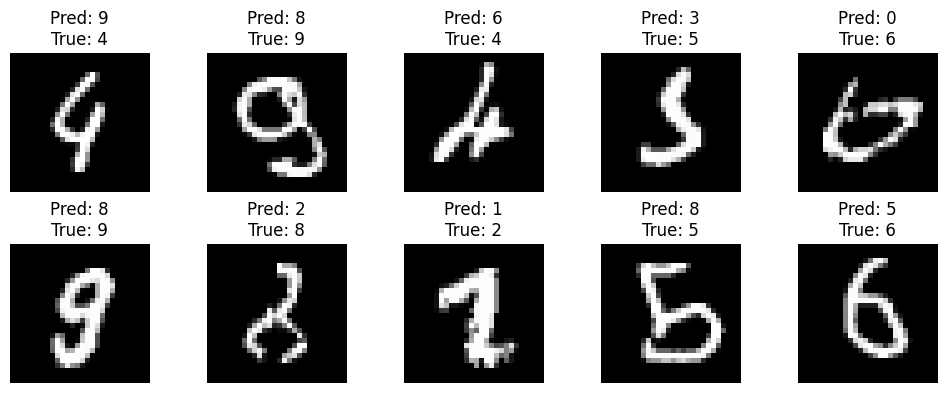

In [16]:
model.eval()
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        mask = preds != labels
        if mask.any():
            wrong_images.append(inputs[mask][0])        # первая ошибка
            wrong_preds.append(preds[mask][0].item())
            wrong_labels.append(labels[mask][0].item())

        if len(wrong_images) >= 10:
            break

# Рисуем
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = wrong_images[i].view(28, 28)  # разворачиваем назад в картинку
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {wrong_preds[i]}\nTrue: {wrong_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# сохраняем модель для дальнейшего использования
torch.save(model.state_dict(), "my_model.pth")
